In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

In [83]:
online_marketing = pd.read_csv("../../data/OnlineMarketingData.csv")
offline_marketing = pd.read_csv("../../data/OfflineMarketingData.csv")
sales = pd.read_csv("../../data/SalesData.csv")
price = pd.read_csv("../../data/PricingData.csv")

In [84]:
# Read sales data and convert to date to datetime
sales['date'] =  pd.to_datetime(sales['date'])

#read offline marketing data and convert week to datetime
offline_marketing['week'] = pd.to_datetime(offline_marketing['week'])

#read online marketing data and convert to datetime
online_marketing['date'] = pd.to_datetime(online_marketing['date'])

In [85]:
# Calculate total daily sales to match with marketing data
daily_sales = sales.groupby('date')['sales_quantity'].sum().reset_index()
daily_sales.rename(columns={'sales_quantity': 'total_sales'}, inplace=True)

In [86]:
# Merge digital data with daily sales for analysis
digital_sales = pd.merge(online_marketing, daily_sales, on='date', how='left')

In [97]:
# Aggregate weekly sales for comparison with weekly media spend
weekly_sales = daily_sales.copy()
weekly_sales['week'] = pd.to_datetime(weekly_sales['date']).dt.to_period('W-SUN').dt.start_time
weekly_sales = weekly_sales.groupby('week')['total_sales'].sum().reset_index()

In [101]:
# Convert 'date' column to datetime
weekly_sales["week"] = pd.to_datetime(weekly_sales["week"])

# Set 'date' as the index for easier manipulation
weekly_sales.set_index("week", inplace=True)
# Shift the data by 1 week
weekly_sales = weekly_sales.shift(periods=1, freq="W")

# If you want to reset the index for easier viewing
weekly_sales.reset_index(inplace=True)

In [102]:
# Merge weekly media spend with weekly sales
media_sales = pd.merge(offline_marketing, weekly_sales, on='week', how='left')

In [114]:
# Aggregate weekly sales for comparison with weekly media spend
weekly_sales_online = digital_sales.copy()
weekly_sales_online['week'] = pd.to_datetime(weekly_sales_online['date']).dt.to_period('W-SUN').dt.start_time
weekly_sales_online = weekly_sales_online.groupby('week')['total_sales'].sum().reset_index()

In [116]:
# Convert 'date' column to datetime
weekly_sales_online["week"] = pd.to_datetime(weekly_sales_online["week"])

# Set 'date' as the index for easier manipulation
weekly_sales_online.set_index("week", inplace=True)
# Shift the data by 1 week
weekly_sales_online = weekly_sales_online.shift(periods=1, freq="W")

# If you want to reset the index for easier viewing
weekly_sales_online.reset_index(inplace=True)

In [117]:
pd.merge(media_sales, weekly_sales_online, how="left", on="week")

,week,channel,spend,total_sales_x,total_sales_y
0,2023-01-01,TV,11311.42,143153,715765
1,2023-01-01,Radio,6723.33,143153,715765
2,2023-01-01,Print,6214.43,143153,715765
3,2023-01-01,OOH,11230.47,143153,715765
4,2023-01-08,TV,14004.01,1009291,5046455
...,...,...,...,...,...
207,2023-12-24,OOH,14623.57,1010115,5050575
208,2023-12-31,TV,12565.47,1002421,5012105
209,2023-12-31,Radio,11167.25,1002421,5012105
210,2023-12-31,Print,9546.23,1002421,5012105


## Task 1: Flawed Adstock Transformation

In [21]:
def calculate_adstock(spend, decay_rate):  
    # print(spend)
    adstock = [0]  # Initialize with zero for the first week  
    for t in range(len(spend)):  
        # print(t, spend[t])
        adstock.append(spend[t] + decay_rate * adstock[-1])  
    return adstock[1:]  # Exclude the first dummy value  

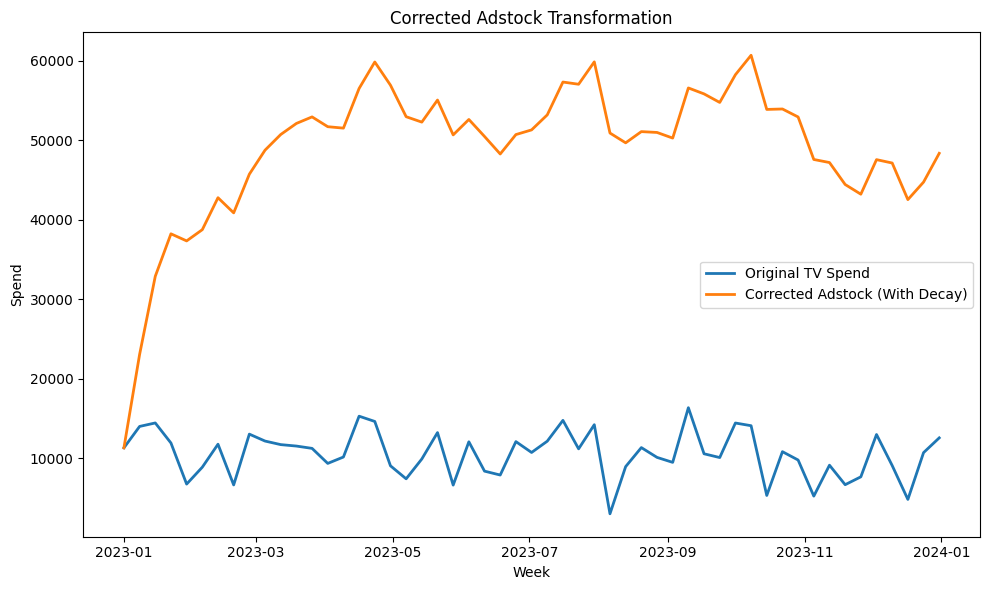

In [27]:
# Define the decay rate  
# A slower decay rate (higher value) will retain the impact of older ads longer, while a faster decay rate (lower value) will fade their influence more quickly.
decay_rate = 0.8
  
# Filter the media data to get only TV spend  
media_df = offline_marketing[offline_marketing['channel'] == 'TV'][['week', 'spend']].copy()  
  
# Rename 'spend' column to 'TV' for consistency  
media_df['TV'] = media_df['spend']  


  
# Calculate the proper adstock transformation using the decay rate  
media_df['TV_adstock'] = calculate_adstock(media_df['TV'].to_list(), decay_rate)  
  
# Plot the original and corrected adstock values  
plt.figure(figsize=(10, 6))  
plt.plot(media_df['week'], media_df['TV'], label='Original TV Spend', linewidth=2)  
plt.plot(media_df['week'], media_df['TV_adstock'], label='Corrected Adstock (With Decay)', linewidth=2)  
plt.title('Corrected Adstock Transformation')  
plt.xlabel('Week')  
plt.ylabel('Spend')  
plt.legend()  
plt.tight_layout()  
plt.show()  

## Task 2: Misleading Diminishing Returns Visualization (No Saturation Effect)

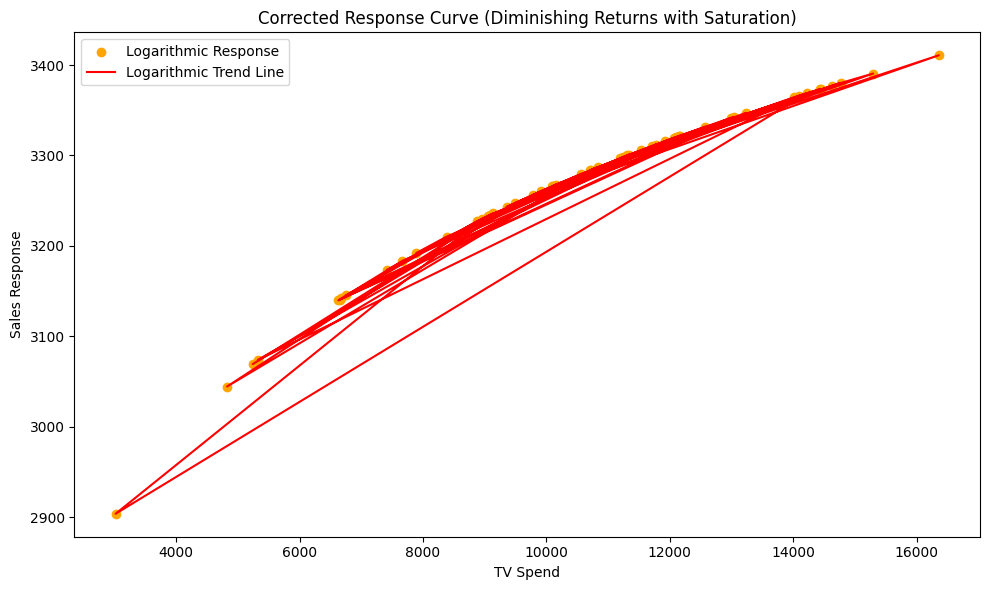

In [30]:
def plot_corrected_diminishing_returns():  
    # Filter the media data to get only TV spend  
    tv_spend = offline_marketing[offline_marketing['channel'] == 'TV']['spend'].values  
      
    # Apply a logarithmic transformation to model diminishing returns  
    response = 500 + 300 * np.log(tv_spend + 1)  # Adding 1 to avoid log(0)  
      
    # Plot the scatter plot  
    plt.figure(figsize=(10, 6))  
    plt.scatter(tv_spend, response, label='Logarithmic Response', color='orange')  
      
    # Add logarithmic trend line  
    plt.plot(tv_spend, response, "r-", label='Logarithmic Trend Line')  
      
    # Add titles and labels  
    plt.title('Corrected Response Curve (Diminishing Returns with Saturation)')  
    plt.xlabel('TV Spend')  
    plt.ylabel('Sales Response')  
    plt.legend()  
    plt.tight_layout()  
    plt.show()  

plot_corrected_diminishing_returns()

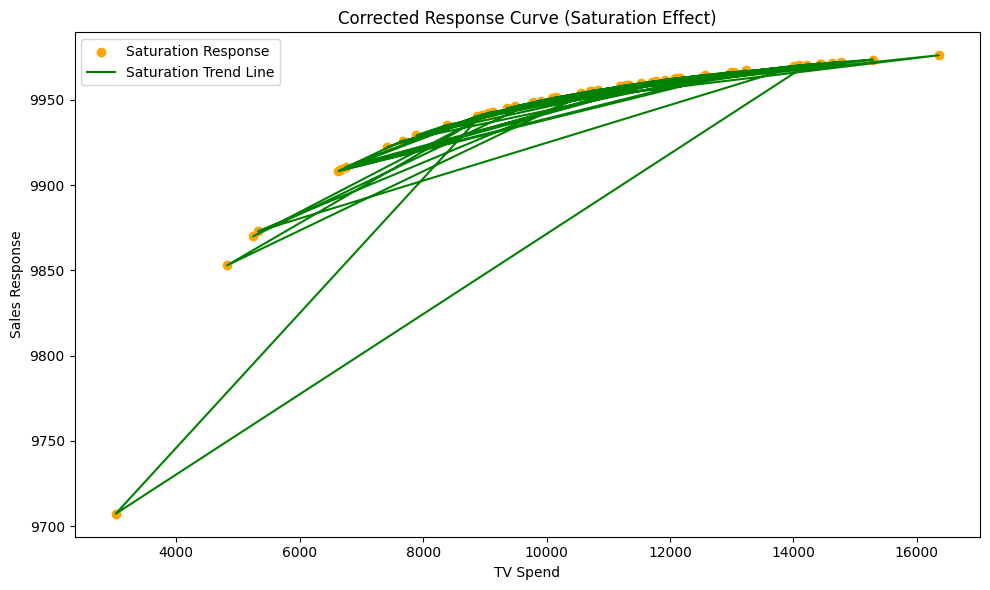

In [ ]:
# going with this method, because in our earlier EDA we have seen, initial sudden rise in sales and then moving at a constant rate.
def plot_corrected_diminishing_returns_saturation():  
    # Filter the media data to get only TV spend  
    tv_spend = offline_marketing[offline_marketing['channel'] == 'TV']['spend'].values  
      
    # Apply a saturation curve to model diminishing returns  
    a = 10000  # Maximum possible sales response (saturation point)  
    b = 1.5    # Controls the steepness of the curve  
    c = 5000   # Scaling factor for TV spend  
    response = (a * (tv_spend ** b)) / (c + (tv_spend ** b))  # Saturation function  
      
    # Plot the scatter plot  
    plt.figure(figsize=(10, 6))  
    plt.scatter(tv_spend, response, label='Saturation Response', color='orange')  
      
    # Add saturation trend line  
    plt.plot(tv_spend, response, "g-", label='Saturation Trend Line')  
      
    # Add titles and labels  
    plt.title('Corrected Response Curve (Saturation Effect)')  
    plt.xlabel('TV Spend')  
    plt.ylabel('Sales Response')  
    plt.legend()  
    plt.tight_layout()  
    plt.show()

plot_corrected_diminishing_returns_saturation()

## Task 3: Incorrect Assessment of Interaction Term in Sales Analysis

In [89]:
offline_channels = ['TV', 'Radio', 'Print', 'OOH']
online_channels = ['Facebook', 'Instagram', 'YouTube', 'Google Ads', 'Influencer Marketing']

          week  log_total_sales  log_interaction_term
0   2023-01-01        11.871676             18.887709
1   2023-01-01        11.871676             18.887709
2   2023-01-01        11.871676             18.887709
3   2023-01-01        11.871676             18.887709
4   2023-01-08        13.824760             19.275753
..         ...              ...                   ...
207 2023-12-24        13.825576             19.088676
208 2023-12-31        13.817930             19.202623
209 2023-12-31        13.817930             19.202623
210 2023-12-31        13.817930             19.202623
211 2023-12-31        13.817930             19.202623

[212 rows x 3 columns]


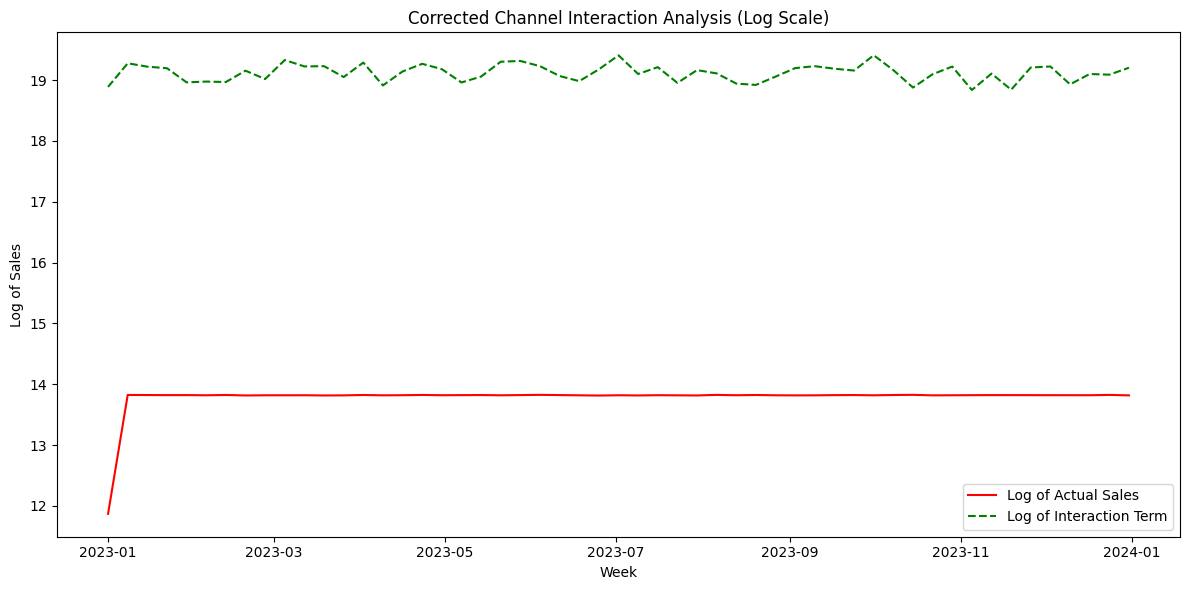

In [122]:
def corrected_interaction_analysis():  
    # Pivot the media_sales data to separate each channel into its own column  
    media_sales_pivoted = media_sales.pivot_table(index='week', columns='channel', values='spend', aggfunc='sum')  
    digital_sales_pivoted = digital_sales.pivot_table(index='date', columns='channel', values='spend', aggfunc='sum')  
  
    # Ensure that all offline and online channels are present, fill missing ones with zeros  
    for channel in offline_channels:  
        if channel not in media_sales_pivoted.columns:  
            media_sales_pivoted[channel] = 0  # Fill missing channels with zero spend  
    for channel in online_channels:  
        if channel not in digital_sales_pivoted.columns:  
            digital_sales_pivoted[channel] = 0  # Fill missing channels with zero spend  
  
    # Calculate the interaction term using the product of online and offline spends  
    media_sales_pivoted['interaction_term'] = (  
        media_sales_pivoted[offline_channels].sum(axis=1) * digital_sales_pivoted[online_channels].sum(axis=1)  
    )  
  
    # Merge total sales into the pivoted data  
    media_sales_pivoted = pd.merge(media_sales_pivoted, media_sales[['week', 'total_sales']], on='week', how='left')  
  
    # Take the logarithmic values to normalize the scale  
    media_sales_pivoted['log_total_sales'] = np.log(media_sales_pivoted['total_sales'] + 1)  # Add 1 to avoid log(0)  
    media_sales_pivoted['log_interaction_term'] = np.log(media_sales_pivoted['interaction_term'] + 1)  # Add 1 to avoid log(0)  
  
    # Debugging output  
    print(media_sales_pivoted[['week', 'log_total_sales', 'log_interaction_term']])  
  
    # Plot the corrected interaction term against actual sales  
    plt.figure(figsize=(12, 6))  
    plt.plot(media_sales_pivoted['week'], media_sales_pivoted['log_total_sales'], label='Log of Actual Sales', color='r')  
    plt.plot(media_sales_pivoted['week'], media_sales_pivoted['log_interaction_term'], label='Log of Interaction Term', color='g', linestyle='--')  
    plt.title('Corrected Channel Interaction Analysis (Log Scale)')  
    plt.xlabel('Week')  
    plt.ylabel('Log of Sales')  
    plt.legend()  
    plt.tight_layout()  
    plt.show()  
  
# Execute the function  
corrected_interaction_analysis()  

## Task 4: Modeling and Visualizing the Adstock Effect

In [ ]:
def plot_adstock_effect():  
    """  
    Function to calculate and plot the adstock effect on media spend.  
    Parameters:  
    - sales_data: DataFrame containing the sales data with 'date' and 'sales_quantity' columns.  
    - media_data: DataFrame containing the media spend data with 'week' and 'spend' columns.  
    - decay_rate: The decay rate to apply to lagged spend (default is 0.5).  
    Returns:  
    - A plot showing the original and adstocked media spend over time.  
    """  
    decay_rate = 0.5  # Decay rate for adstock effect  
  
    # Calculate total daily sales to match with marketing data  
    daily_sales = sales.groupby('date')['sales_quantity'].sum().reset_index()  
    daily_sales.rename(columns={'sales_quantity': 'total_sales'}, inplace=True)  
  
    # Aggregate weekly sales for comparison with weekly media spend  
    weekly_sales = daily_sales.copy()  
    weekly_sales['week'] = pd.to_datetime(weekly_sales['date']).dt.to_period('W').dt.start_time  
    weekly_sales = weekly_sales.groupby('week')['total_sales'].sum().reset_index()  
  
    # Merge media spend with weekly sales  
    media_sales = pd.merge(offline_marketing, weekly_sales, on='week', how='left')  
  
    # Calculate the adstock effect dynamically over multiple lag periods  
    media_sales['TV_adstock'] = 0  # Initialize adstock column  
    for lag in range(0, 10):  # Use 10 lag periods to capture longer-term effects  
        media_sales[f'TV_lag{lag}'] = media_sales['spend'].shift(lag) * (decay_rate ** lag)  
        media_sales['TV_adstock'] += media_sales[f'TV_lag{lag}']  
  
    # Handle missing values (NaN) in lagged columns by filling with zero  
    media_sales.fillna(0, inplace=True)  
  
    # Plotting the results  
    plt.figure(figsize=(12, 6))  
    plt.plot(media_sales['week'], media_sales['spend'], label='Original TV Spend', marker='o', color='blue')  
    plt.plot(media_sales['week'], media_sales['TV_adstock'], label='Adstocked TV Spend (Decay)', marker='x', linestyle='--', color='orange')  
      
    # Add title, labels, and legend  
    plt.title(f'Adstock Effect with Decay Rate ({decay_rate})')  
    plt.xlabel('Week')  
    plt.ylabel('Spend')  
    plt.legend()  
    plt.tight_layout()  
    plt.show()  

plot_adstock_effect()

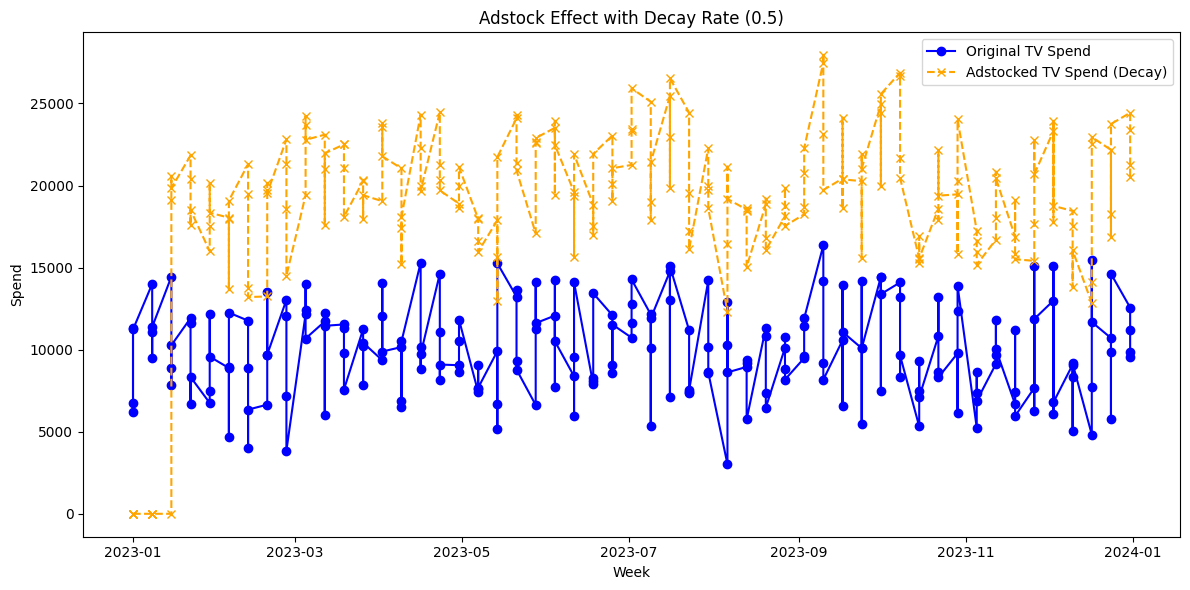